In [1]:
from duckduckgo_search import DDGS
import fastai.vision.all as fv
import fastcore.all as fc
from fastdownload import download_url
import skimage.io as io
import matplotlib.pyplot as plt

In [2]:
from duckduckgo_search.duckduckgo_search_async import AsyncDDGS
from fastcore.foundation import L


async def search(q):
    async with AsyncDDGS() as ddgs:
        image_gen = ddgs.images(keywords=q, max_results=30)
        imglist = [item["image"] async for item in image_gen]
    return imglist


categories = ("pacman", "tetris")
path = fc.Path("images")
path.mkdir()
for label in categories:
    dest = path / label
    dest.mkdir(exist_ok=True)
    imglist = await search(label)
    fv.download_images(dest=dest,urls=imglist)

d:\fastaiDL\env\Lib\site-packages\curl_cffi\aio.py:192: UserWarning: Curlm alread closed! quitting from process_data
  warnings.warn("Curlm alread closed! quitting from process_data")


In [3]:
from fastai.data.transforms import get_image_files
from fastai.vision.utils import resize_images, verify_images

for label in categories:
    dest = path/label
    failed = verify_images(get_image_files(dest))
    failed.map(fc.Path.unlink)

In [4]:
from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.transforms import RandomSplitter, parent_label
from fastai.vision.augment import RandomResizedCrop, Resize, aug_transforms
from fastai.vision.data import ImageBlock



dls = DataBlock(
    blocks=[ImageBlock,CategoryBlock], 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(224,min_scale=0.3) ],
    batch_tfms=aug_transforms()
).dataloaders(path, bs=5)


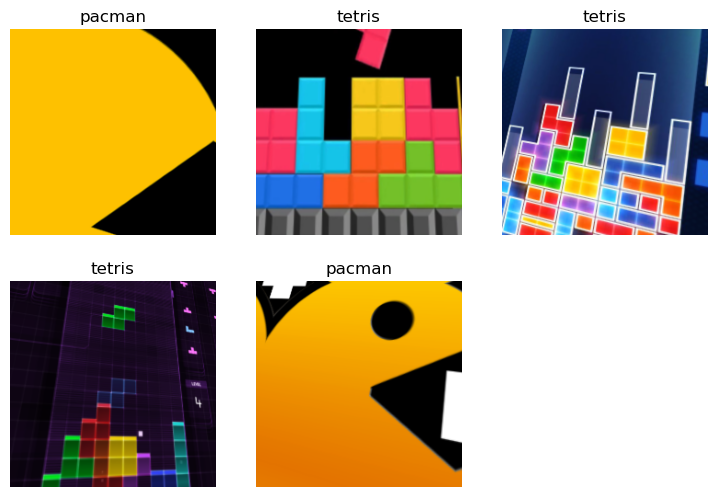

In [5]:
dls.show_batch()


In [6]:
from fastai.metrics import error_rate
from fastai.vision.learner import vision_learner
from torchvision.models.resnet import resnet18


l = vision_learner(dls,resnet18,metrics=error_rate)
l.fine_tune(3)


epoch,train_loss,valid_loss,error_rate,time
0,0.871373,0.598529,0.200000,00:05


d:\fastaiDL\env\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.482177,0.576641,0.200000,00:07
1,0.402436,0.171994,0.100000,00:06
2,0.375074,0.091619,0.100000,00:06


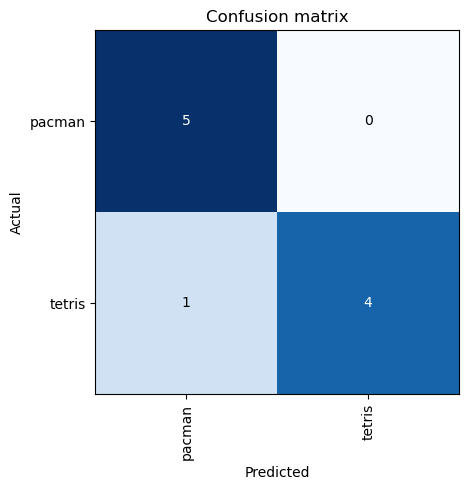

In [7]:
from fastai.interpret import ClassificationInterpretation


interp = ClassificationInterpretation.from_learner(l)
interp.plot_confusion_matrix()

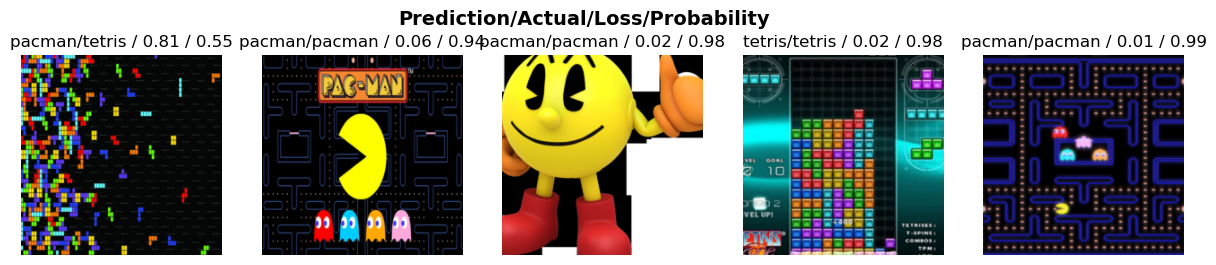

In [8]:
interp.plot_top_losses(5, nrows=1)

In [13]:
from fastai.vision.widgets import ImageClassifierCleaner


cleaner = ImageClassifierCleaner(l)
cleaner

d:\fastaiDL\env\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:

for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

FileUpload(value={}, description='Upload')

In [12]:
l.export('model.pkl')